# Inception

- https://machinelearningmastery.com/how-to-implement-major-architecture-innovations-for-convolutional-neural-networks/
- https://www.analyticsvidhya.com/blog/2018/10/understanding-inception-network-from-scratch/


In [1]:
# Example of creating a CNN model with a VGG block
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [2]:
mnist = tf.keras.datasets.mnist

(X_train_, y_train), (X_test_, y_test) = mnist.load_data()
X_train_, X_test_ = (
    X_train_.astype(np.float32) / 255.0,
    X_test_.astype(np.float32) / 255.0,
)

# Add another dimension
X_train = X_train_[..., np.newaxis]
X_test = X_test_[..., np.newaxis]
print(X_train.shape)
print(X_test.shape)

# Reduce dimension size
np.random.seed(0)

REDUCE_DIM = 2000
idx = np.random.permutation(REDUCE_DIM)

X_train = X_train[idx]
y_train = y_train[idx]
X_test = X_test[idx]
y_test = y_test[idx]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import plot_model

In [12]:
# function for creating a naive inception block
def naive_inception_module(layer_in, f1, f2, f3):
    # 1x1 conv
    conv1 = Conv2D(f1, (1, 1), padding="same", activation="relu")(layer_in)
    # 3x3 conv
    conv3 = Conv2D(f2, (3, 3), padding="same", activation="relu")(layer_in)
    # 5x5 conv
    conv5 = Conv2D(f3, (5, 5), padding="same", activation="relu")(layer_in)
    # 3x3 max pooling
    pool = MaxPooling2D((3, 3), strides=(1, 1), padding="same")(layer_in)
    # concatenate filters, assumes filters/channels last
    layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
    return layer_out

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 256         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 128 3584        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 32) 2432        input_1[0][0]                    
______________________________________________________________________________________________

2021-09-21 20:39:43.669227: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-21 20:39:43.669411: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-21 20:39:43.670428: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


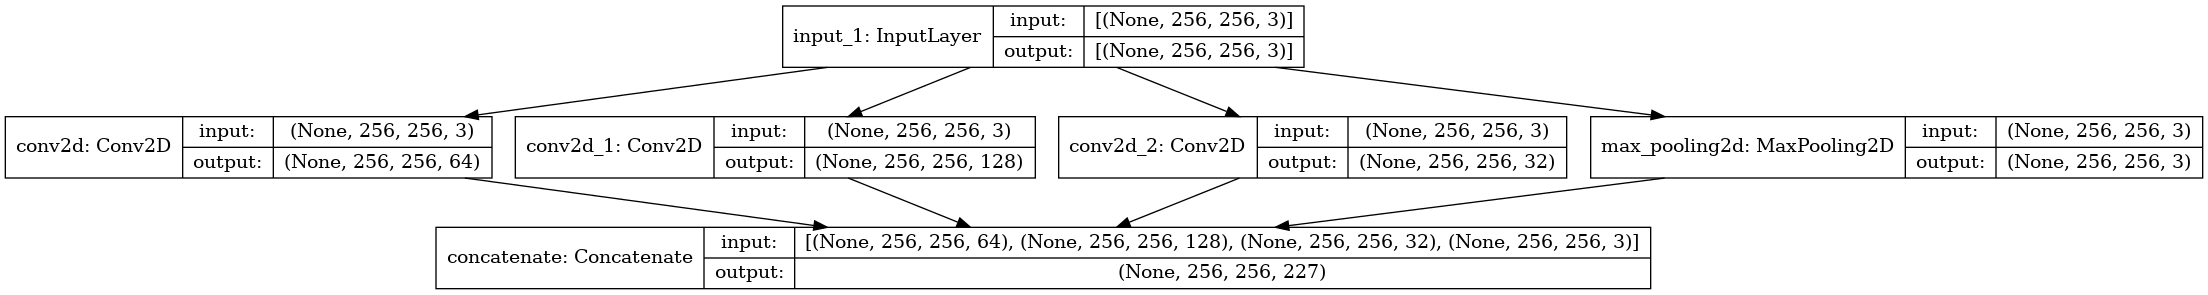

In [13]:
# define model input
visible = Input(shape=(256, 256, 3))
# add inception module
layer = naive_inception_module(visible, 64, 128, 32)
# create model
model = Model(inputs=visible, outputs=layer)
# summarize model
model.summary()
# plot model architecture
plot_model(model, show_shapes=True, to_file="naive_inception_module.png")

In [14]:
# function for creating a projected inception module
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
    # 1x1 conv
    conv1 = Conv2D(f1, (1, 1), padding="same", activation="relu")(layer_in)
    # 3x3 conv
    conv3 = Conv2D(f2_in, (1, 1), padding="same", activation="relu")(layer_in)
    conv3 = Conv2D(f2_out, (3, 3), padding="same", activation="relu")(conv3)
    # 5x5 conv
    conv5 = Conv2D(f3_in, (1, 1), padding="same", activation="relu")(layer_in)
    conv5 = Conv2D(f3_out, (5, 5), padding="same", activation="relu")(conv5)
    # 3x3 max pooling
    pool = MaxPooling2D((3, 3), strides=(1, 1), padding="same")(layer_in)
    pool = Conv2D(f4_out, (1, 1), padding="same", activation="relu")(pool)
    # concatenate filters, assumes filters/channels last
    layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
    return layer_out

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 256, 256, 96) 384         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 256, 256, 16) 64          input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 256, 256, 3)  0           input_2[0][0]                    
____________________________________________________________________________________________

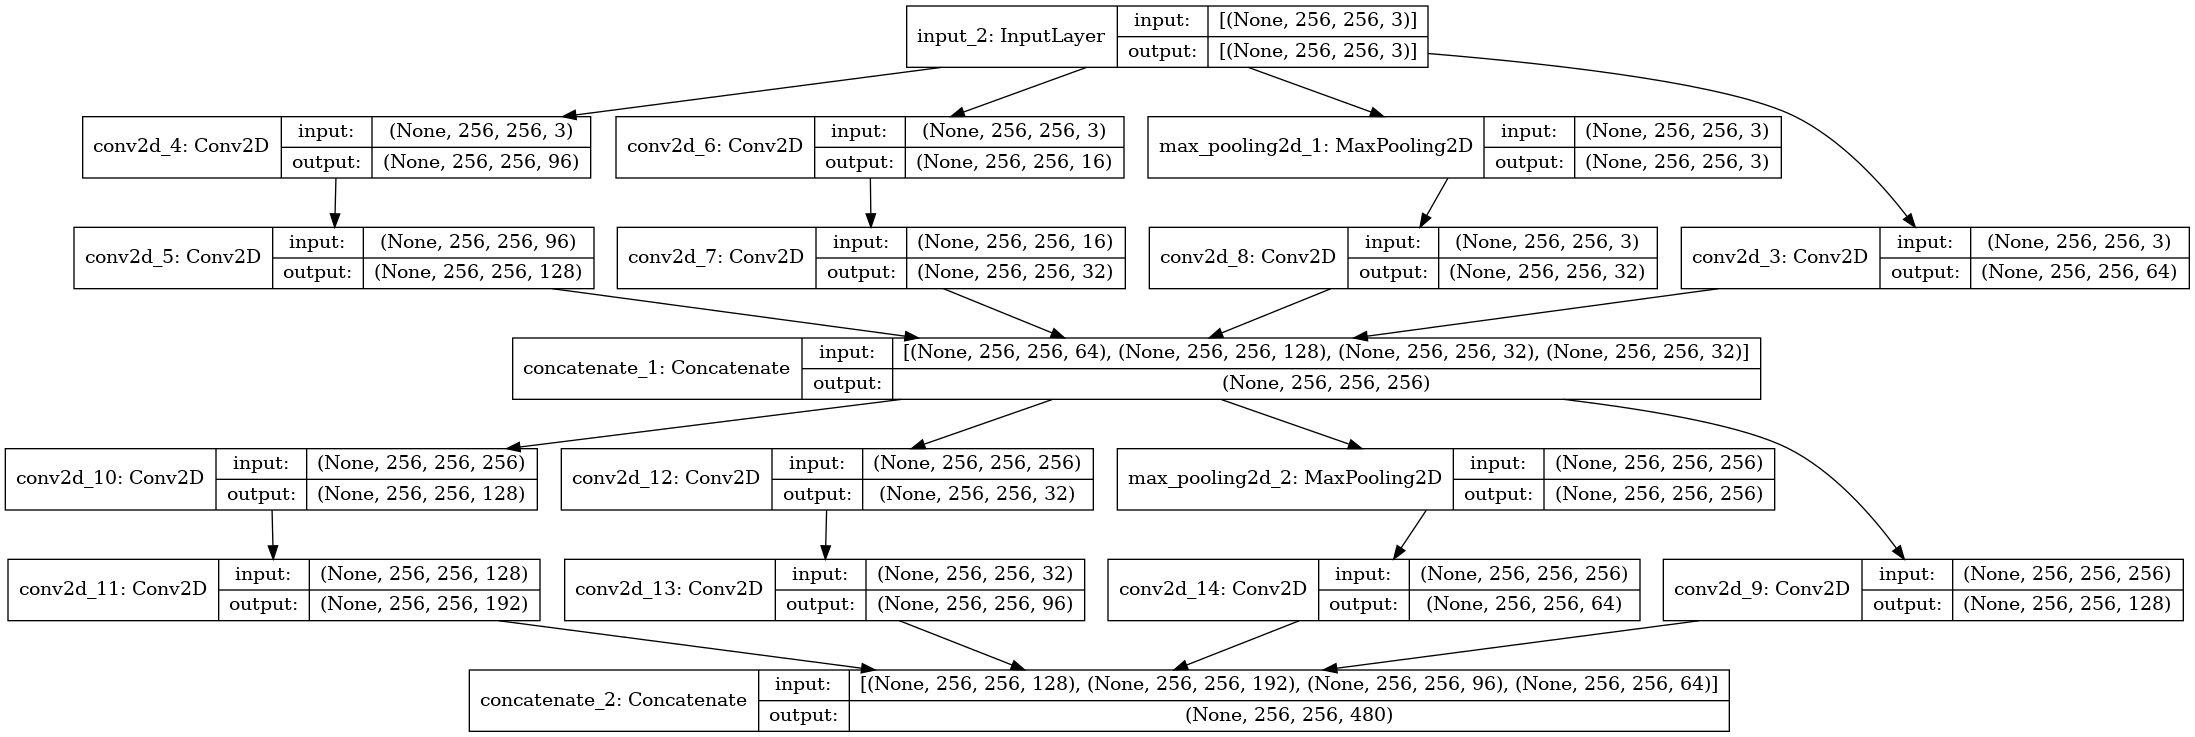

In [15]:
# define model input
visible = Input(shape=(256, 256, 3))
# add inception block 1
layer = inception_module(visible, 64, 96, 128, 16, 32, 32)
# add inception block 1
layer = inception_module(layer, 128, 128, 192, 32, 96, 64)
# create model
model = Model(inputs=visible, outputs=layer)
# summarize model
model.summary()
# plot model architecture
plot_model(model, show_shapes=True, to_file="inception_module.png")

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 96)   192         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 28, 28, 16)   32          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 28, 28, 1)    0           input_1[0][0]                    
______________________________________________________________________________________________

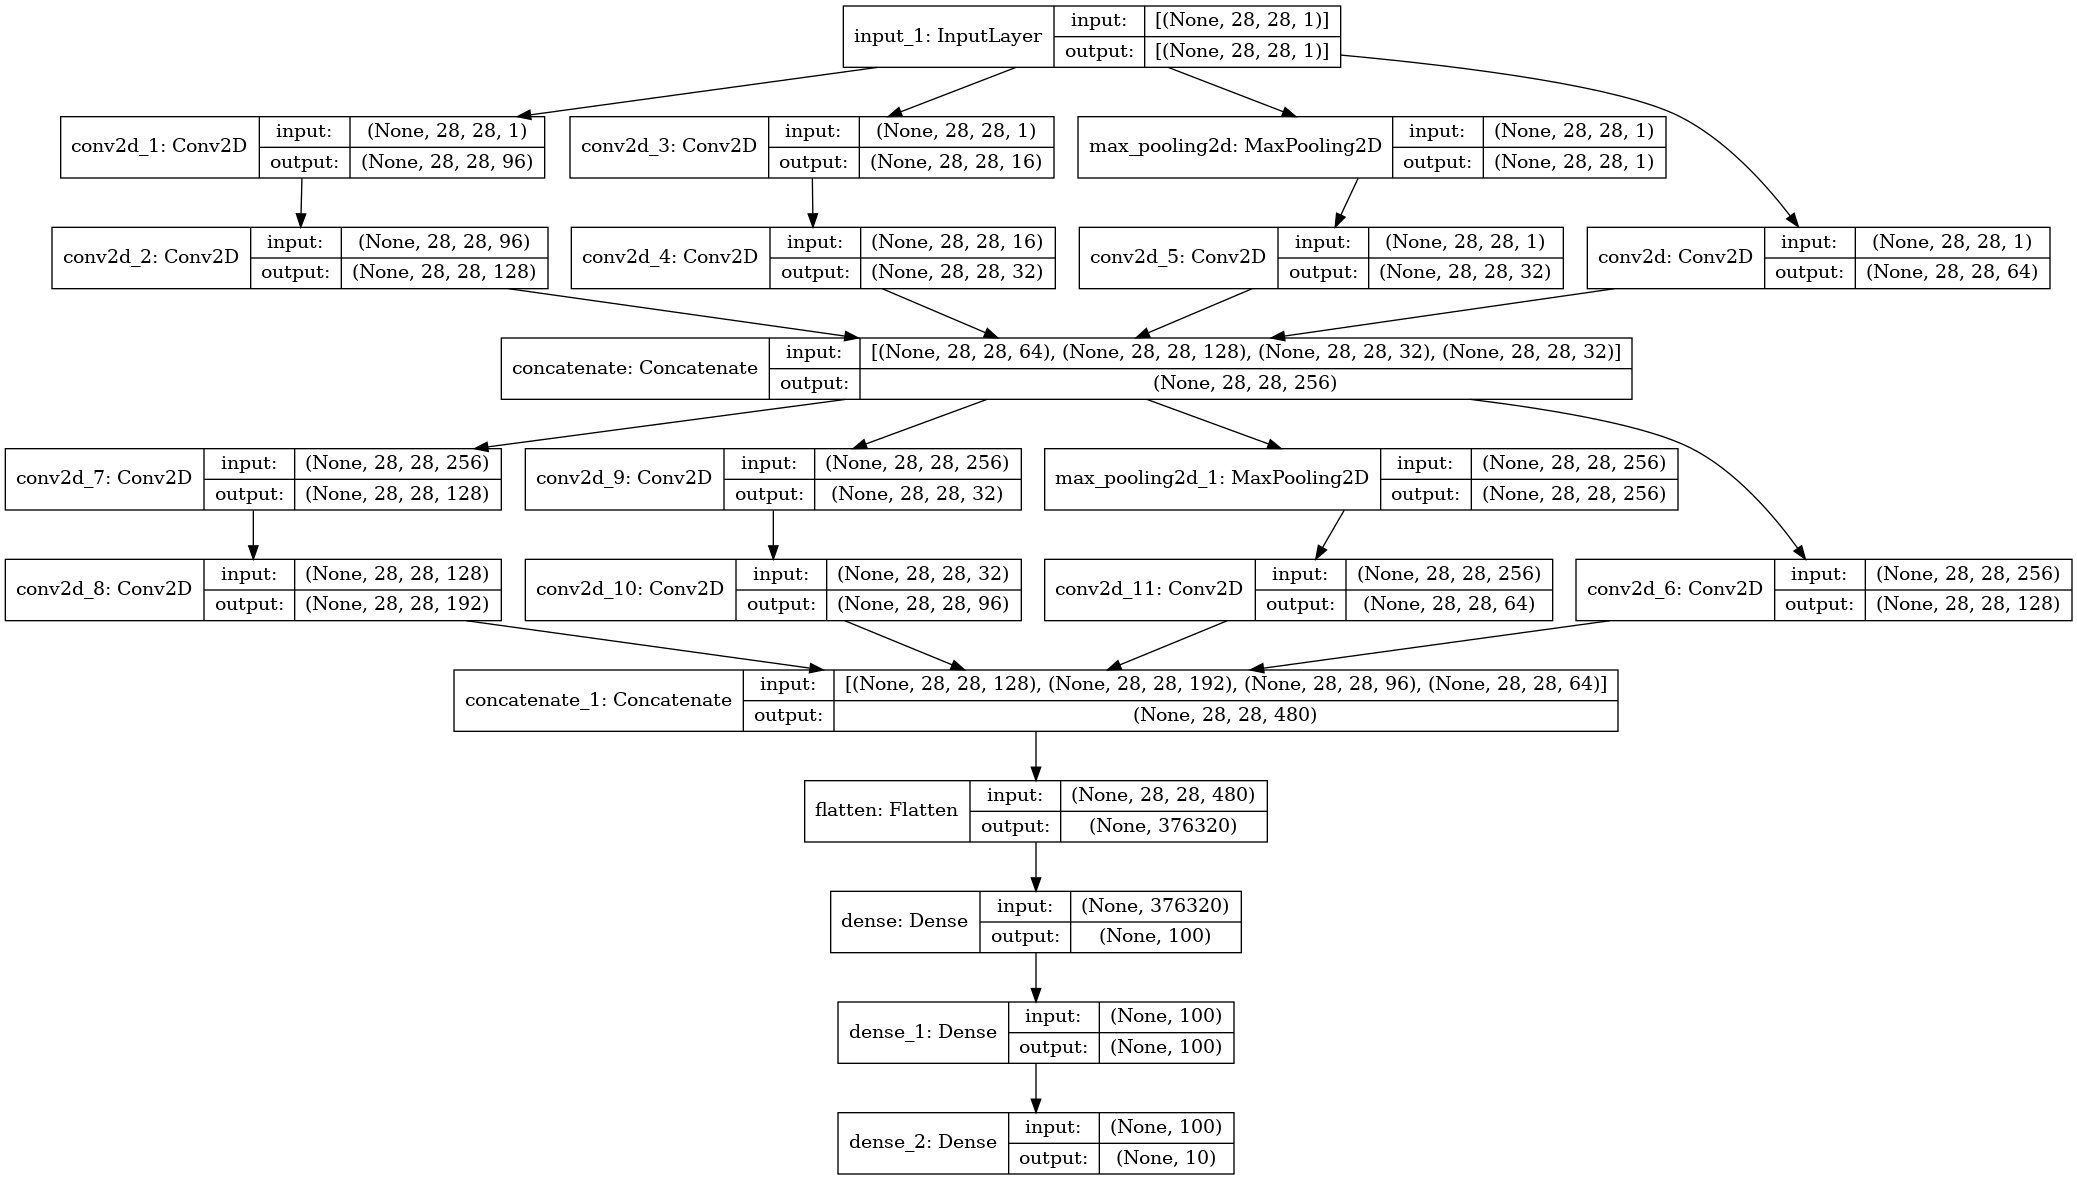

In [16]:
tf.keras.backend.clear_session()
# define model input
visible = Input(shape=(28, 28, 1))
# add inception block 1
layer = inception_module(visible, 64, 96, 128, 16, 32, 32)
# add inception block 1
layer = inception_module(layer, 128, 128, 192, 32, 96, 64)

# Flatten
layer = Flatten()(layer)

layer = Dense(100, activation="relu")(layer)
layer = Dense(100, activation="relu")(layer)
layer = Dense(10, activation="softmax")(layer)

# create model
model = Model(inputs=visible, outputs=layer)
# summarize model
model.summary()
# plot model architecture
plot_model(model, show_shapes=True, to_file="multiple_vgg_blocks.png")

In [17]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)  # same as `tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')`

In [20]:
history = model.fit(X_train, y_train, epochs=5, validation_split=0.1)

Epoch 1/5
57/57 [==============================] - 40s 707ms/step - loss: 0.2149 - accuracy: 0.9372 - val_loss: 0.2330 - val_accuracy: 0.9300
Epoch 2/5
57/57 [==============================] - 38s 665ms/step - loss: 0.0751 - accuracy: 0.9789 - val_loss: 0.2572 - val_accuracy: 0.9150
Epoch 3/5
57/57 [==============================] - 39s 677ms/step - loss: 0.0251 - accuracy: 0.9917 - val_loss: 0.2923 - val_accuracy: 0.9250
Epoch 4/5
57/57 [==============================] - 38s 672ms/step - loss: 0.0283 - accuracy: 0.9889 - val_loss: 0.2606 - val_accuracy: 0.9450
Epoch 5/5
57/57 [==============================] - 38s 664ms/step - loss: 0.0248 - accuracy: 0.9917 - val_loss: 0.4331 - val_accuracy: 0.9150


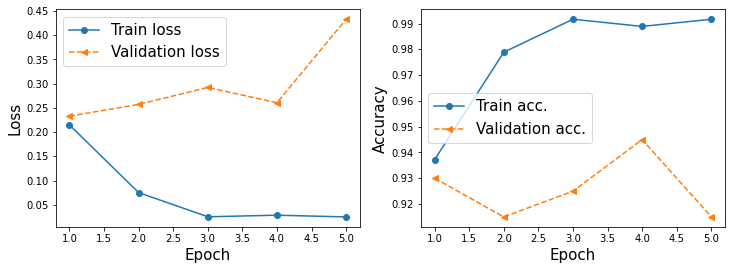

In [21]:
hist = history.history
x_arr = np.arange(len(hist["loss"])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist["loss"], "-o", label="Train loss")
ax.plot(x_arr, hist["val_loss"], "--<", label="Validation loss")
ax.set_xlabel("Epoch", size=15)
ax.set_ylabel("Loss", size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist["accuracy"], "-o", label="Train acc.")
ax.plot(x_arr, hist["val_accuracy"], "--<", label="Validation acc.")
ax.legend(fontsize=15)
ax.set_xlabel("Epoch", size=15)
ax.set_ylabel("Accuracy", size=15)

# plt.savefig('figures/15_12.png', dpi=300)
plt.show()

In [22]:
test_results = model.evaluate(X_test, y_test)
print("\nTest Acc. {:.2f}%".format(test_results[1] * 100))

63/63 [==============================] - 10s 151ms/step - loss: 0.4720 - accuracy: 0.8960

Test Acc. 89.60%


In [23]:
# Find misclassification
y_pred_tf = model(X_test)
y_pred_tf.numpy().shape

y_pred = tf.math.argmax(y_pred_tf, axis=1).numpy()
print(y_pred.shape)
print(y_test.shape)

loc = y_pred != y_test
print(f"Missclassification = {loc.sum()}")

(2000,)
(2000,)
Missclassification = 208


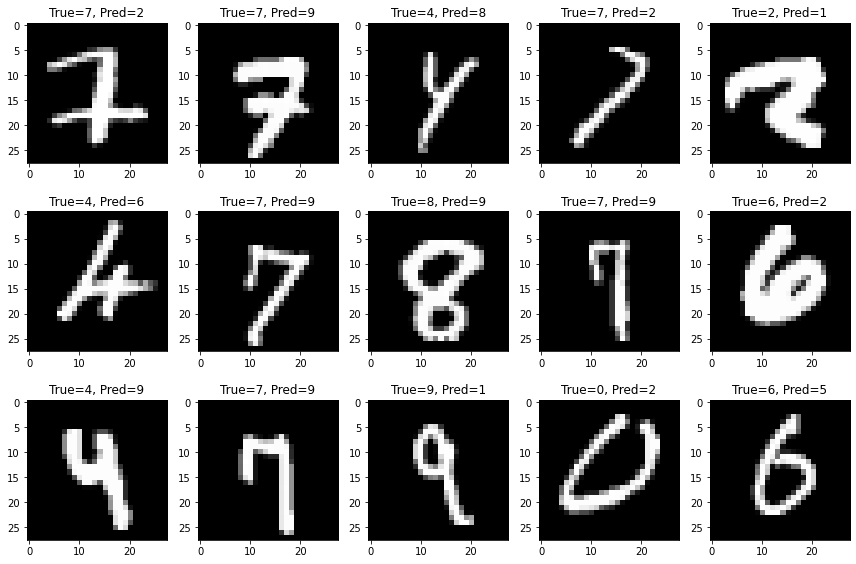

In [24]:
fig, axes2D = plt.subplots(3, 5, figsize=(12, 8))
axes = list(itertools.chain.from_iterable(axes2D))  # Flatten 2D list
X_test_miss = X_test[loc]
y_test_miss = y_test[loc]
y_pred_miss = y_pred[loc]
for idx, ax in enumerate(axes):
    ax.imshow(X_test_miss[idx], cmap="gray")
    ax.set_title(f"True={y_test_miss[idx]}, Pred={y_pred_miss[idx]}")
fig.tight_layout()
plt.show()